In [1]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 




In [5]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [6]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [7]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [8]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [9]:
#This updates the stim ids with the new ones 
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [10]:
epochUpdate = update_stim_code(epoch)
epochUpdate.events.shape

(5424, 3)

In [11]:
#updated stim codes event keys
epochUpdate.event_id

{'b-f1-pic': 8,
 'b-f1-snd': 11,
 'b-f1-spk': 5,
 'b-f1-wrd': 2,
 'b-f2-pic': 7,
 'b-f2-snd': 10,
 'b-f2-spk': 4,
 'b-f2-wrd': 1,
 'b-tg-pic': 9,
 'b-tg-snd': 12,
 'b-tg-spk': 6,
 'b-tg-wrd': 3,
 'congruent': 133,
 'correct': 129,
 'f-f1-pic': 20,
 'f-f1-snd': 23,
 'f-f1-spk': 17,
 'f-f1-wrd': 14,
 'f-f2-pic': 19,
 'f-f2-snd': 22,
 'f-f2-spk': 16,
 'f-f2-wrd': 13,
 'f-tg-pic': 21,
 'f-tg-snd': 24,
 'f-tg-spk': 18,
 'f-tg-wrd': 15,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,
 'incongruent': 134,
 'incorrect': 130,
 'left_button': 131,
 'right_button': 132,
 't_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'trail_start': 31}

In [12]:
#combinations of stim events and what they represent
#For example, AALL -> A-AL-L Combining the first and last is AL which means audio language flanker.
                    # The middle two letters represent the target which is audio lanuguage.
                    # Audio language means spoken word.
                    #flanker1,target, and flanker2 are all spoken words.
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
}

In [13]:
"""
find stim combinations in each trial that equals VVLL, VVLN, VVNL, VVNN
and AALL,AALN, AANL, AANN

and label combinations that start with 'V' 100 and starting with 'A' as 200 
"""

events = epochUpdate.events
events_new = []
temp = []
combo = []

count = 0
for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVLL" or \
                stim_combinations[combo_tuple] == "VVLN" or \
                stim_combinations[combo_tuple] == "VVNL" or \
                stim_combinations[combo_tuple] == "VVNN":
                
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100

            elif stim_combinations[combo_tuple] == "AALL" or \
                stim_combinations[combo_tuple] == "AALN" or \
                stim_combinations[combo_tuple] == "AANL" or \
                stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for m in temp:
                    if m[-1] >= 1 and m[-1] <= 24:
                        #print(k)
                        m[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

#print(count)

[array([2593,    0,  100]),
 array([2718,    0,  100]),
 array([2847,    0,  100]),
 array([3682,    0,  100]),
 array([3807,    0,  100]),
 array([3936,    0,  100]),
 array([4500,    0,  100]),
 array([4625,    0,  100]),
 array([4754,    0,  100]),
 array([5043,    0,  100]),
 array([5168,    0,  100]),
 array([5297,    0,  100]),
 array([5581,    0,  100]),
 array([5706,    0,  100]),
 array([5835,    0,  100]),
 array([6120,    0,  100]),
 array([6244,    0,  100]),
 array([6374,    0,  100]),
 array([6658,    0,  100]),
 array([6778,    0,  100]),
 array([6912,    0,  100]),
 array([7200,    0,  100]),
 array([7321,    0,  100]),
 array([7454,    0,  100]),
 array([7739,    0,  100]),
 array([7864,    0,  100]),
 array([7993,    0,  100]),
 array([8281,    0,  100]),
 array([8406,    0,  100]),
 array([8535,    0,  100]),
 array([8820,    0,  100]),
 array([8944,    0,  100]),
 array([9074,    0,  100]),
 array([9358,    0,  100]),
 array([9483,    0,  100]),
 array([9612,    0, 

In [14]:
#Select events and their data that start with 100 or 200(visual or audio combinations)
TwoEventEpoch = \
            epochUpdate[(epochUpdate.events[:,-1]==100) | (epochUpdate.events[:,-1]==200)].copy()

In [15]:
type(TwoEventEpoch)

mne.epochs.EpochsFIF

In [16]:
#shape of reduced data epoch
TwoEventEpoch.get_data().shape

(1254, 129, 180)

In [17]:
#shape or original epoch
epochUpdate.get_data().shape

(5424, 129, 180)

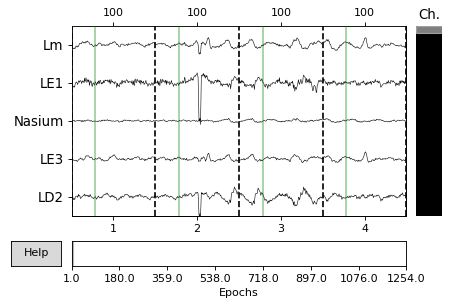

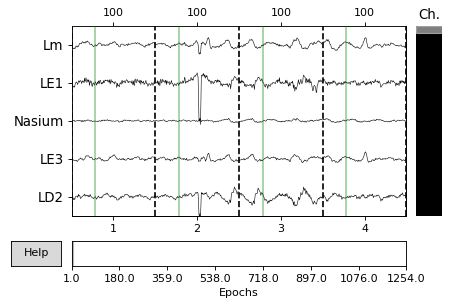

In [18]:
TwoEventEpoch.plot(n_channels=5,n_epochs=4)

In [19]:
#Start of classification task with LogReg
"""
Store epoch data in variable and store epoch events in variable
print shape of both variables to check for consistency
"""
features = TwoEventEpoch.get_data()
target = TwoEventEpoch.events[:,-1]

print("shape of data",features.shape)

print("shape of target array",target.shape)

shape of data (1254, 129, 180)
shape of target array (1254,)


In [20]:
"""
pipeling for converting data from 3D to 2D using vectorizer and
LogisticRegression for classification 
"""

clf = make_pipeline(Vectorizer(),LogisticRegression())

cv = StratifiedKFold(n_splits=10,shuffle=True)
score = []
for train,test in cv.split(features,target):
    X_train = features[train]; y_train = target[train] 
    X_test = features[test];   y_test = target[test]

    clf.fit(X_train,y_train)
    score.append(clf.score(X_test,y_test))

In [21]:
print("mean classification score", np.mean(score))

mean classification score 0.7161015873015872


In [27]:
"""
get the coeficients after fitting clf to training sets
"""
from mne.decoding import get_coef
coefficients= get_coef(clf,'coef_')
print(coefficients.shape)

(1, 23220)


In [28]:
"""Shape coeficients data to 129 by 180"""
hold = []
for h in range(0,23219,180):
    temp = []
    for i in range(h,h+180):
        temp.append(coefficients[0][i])
    hold.append(temp)     
npHold = np.array(hold)
npHold.shape

(129, 180)

In [32]:
"""View Coeficients data in dataframe"""
import pandas as pd
df = pd.DataFrame(npHold)
df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,2.055436e-07,-6.303650e-06,2.494496e-05,-1.516285e-05,2.405528e-05,2.652343e-05,-1.365788e-06,-6.765487e-06,-1.898722e-06,-2.160625e-05,...,1.008962e-05,4.475903e-05,5.473489e-05,6.790920e-05,-1.245071e-05,-9.780849e-05,3.045116e-05,8.236387e-05,7.668315e-06,4.618975e-06
1,5.830423e-05,1.016087e-04,1.390053e-04,6.196501e-05,2.528506e-05,1.274618e-05,1.391261e-05,-5.557743e-05,-7.524411e-05,-2.161464e-05,...,3.810433e-05,3.464117e-05,-1.278802e-05,4.064624e-05,2.585686e-05,3.564705e-06,5.383632e-05,5.657494e-06,1.569514e-05,9.129366e-06
2,-5.620813e-06,1.004877e-05,2.352151e-05,1.519072e-06,8.669534e-06,3.101790e-06,1.009730e-05,3.813940e-06,-1.915513e-06,8.142593e-07,...,1.050509e-06,-3.320511e-06,-5.807186e-06,-2.414149e-06,-7.095833e-06,-1.086467e-05,-8.111172e-06,-6.613192e-06,-1.948626e-06,-1.319733e-06
3,9.389687e-06,-7.632321e-06,-6.078002e-07,4.160722e-06,-7.389088e-07,1.433337e-05,-1.687733e-05,-3.146009e-05,-2.064091e-05,-6.706144e-06,...,-2.125288e-05,4.011671e-06,8.059439e-06,2.453211e-05,2.167588e-05,-2.612366e-05,1.283230e-05,2.161592e-05,-1.672420e-06,6.644665e-06
4,6.177152e-05,7.023991e-05,1.022068e-04,2.739282e-05,2.365125e-05,4.060093e-05,-2.819782e-05,-4.402611e-05,-2.210406e-05,-2.772094e-05,...,6.484958e-05,-1.641849e-05,2.649939e-05,2.868866e-05,5.177027e-05,7.158518e-05,6.164059e-05,7.862953e-06,-3.689154e-05,7.261927e-05
5,1.184195e-05,3.266372e-06,3.967630e-05,1.081087e-05,3.592616e-05,6.297222e-05,-5.382635e-05,-2.647844e-05,-1.232728e-05,-1.940078e-05,...,1.839365e-05,3.471252e-05,2.704367e-05,5.467466e-05,3.150325e-05,1.742046e-05,2.544367e-05,1.245169e-06,1.143199e-05,5.094909e-06
6,-4.307118e-05,-6.301686e-06,1.937538e-04,9.581302e-06,-1.915176e-05,5.084173e-05,-3.544046e-05,-9.309108e-05,-9.400380e-07,2.084190e-05,...,-3.314035e-05,-8.573502e-05,1.515518e-05,7.503665e-05,6.614566e-05,5.328171e-05,8.622589e-05,3.519662e-05,-2.270124e-05,-1.917442e-06
7,-1.900663e-05,1.701849e-05,4.220855e-06,-5.258691e-06,5.859109e-06,-1.269687e-05,-9.718830e-06,-2.016951e-05,7.166189e-06,1.329630e-05,...,-8.069461e-06,8.818805e-06,1.089256e-05,1.115148e-06,2.939539e-05,3.018911e-06,1.890609e-05,2.870714e-05,9.632530e-07,2.981302e-05
8,5.580565e-05,-1.195582e-06,3.522875e-07,8.248883e-05,-4.888712e-07,-6.315674e-05,2.722324e-05,2.453888e-05,-2.300382e-05,-1.328412e-05,...,-1.549850e-06,2.983914e-05,-2.094634e-05,-1.320915e-06,3.983041e-05,4.383202e-05,2.509664e-05,1.478835e-05,4.622866e-05,1.134792e-05
9,1.686524e-05,9.716901e-06,-2.259019e-05,3.509003e-05,2.257150e-05,-7.846481e-05,1.678292e-05,4.533417e-05,-2.558013e-05,2.942596e-05,...,8.492819e-06,-1.373658e-05,-2.615776e-06,-1.089458e-05,3.145716e-05,3.165038e-05,-1.868790e-05,1.550882e-05,3.633423e-05,3.347175e-05
